In [40]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras as keras
from numpy import newaxis
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM, GRU, RNN
from keras.models import Sequential
from keras import optimizers


# Step 1. Loading data

In [41]:
# path must be specified relatively notebook 
PATH = "../data/eurusd_m1_202103.csv"
COLUMNS = ["offset", "open", "high", "low", "close"]
df_train = pd.read_csv(PATH, skipinitialspace=True, names = COLUMNS, index_col=False, sep=';')
df_train.shape
df_train.head(5)

,offset,open,high,low,close
0,0,1.20776,1.20783,1.20776,1.20783
1,100,1.20783,1.20791,1.20783,1.20789
2,200,1.20789,1.20802,1.20788,1.20798
3,300,1.20798,1.20802,1.20793,1.20793
4,400,1.20793,1.20798,1.20793,1.20796


In [135]:
# Enter in how much steps we will enroll the network.
# RNN/LSTM/GRU can be taught patterns over times series as big as the number of times you enrol them, and no bigger (fundamental limitation). 
# So by design these networks are deep/long to catch recurrent patterns.
Enrol_window = 100



# Step 2. Define auxilary routines



In [125]:
def load_data(datasetname, column, seq_len, normalise_window):
    # extract column from the data set
    data = datasetname.loc[:,column]

    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    if normalise_window:
        result = normalise_windows(result)

    result = np.array(result)

    # split all set into 2 parts - training set and test one
    pivot_point = int(round(0.9 * result.shape[0]))
    train = result[:pivot_point,:]
    np.random.shuffle(train)
    x_train = train[:,:-1]
    y_train = train[:,-1]
    x_test = result[pivot_point:,:-1]
    y_test = result[pivot_point:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test, pivot_point]

def normalise_windows(window_data):
    # A support function to normalize a dataset
    normalised_data = []
    for window in window_data:
        normalised_window = []
        first = True
        base = 1
        for p in window:
            if first:
                base = p
                first = False
            normalised_window.append(1000* ((float(p) / float(base)) - 1))
        normalised_data.append(normalised_window)
    return normalised_data

def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of <prediction_len> steps before shifting prediction run forward by <prediction_len> steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

def plot_results(predicted_data, true_data): 
    fig = plt.figure(facecolor='white') 
    ax = fig.add_subplot(111) 
    ax.plot(true_data, label='True Data') 
    plt.plot(predicted_data, label='Prediction') 
    plt.legend() 
    plt.show() 
    
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

print ('Support functions defined')

Support functions defined


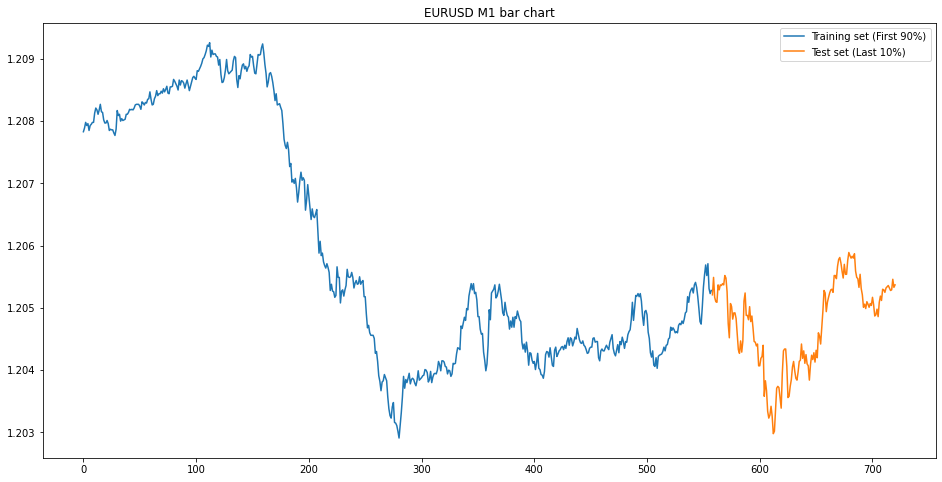

In [144]:
# Prepare the dataset, note that the stock price data will be normalized between 0 and 1
# A label is the thing we're predicting
# A feature is an input variable, in this case a stock price
# Selected 'Close' (stock pric at closing) attribute for prices. Let's see what it looks like

feature_train, label_train, feature_test, label_test, split = load_data(df_train, 'close', Enrol_window, True)

df_train["close"][:split].plot(figsize=(16,8),legend=True)
df_train["close"][split:].plot(figsize=(16,8),legend=True) # 10% is used for thraining data which is approx 2017 data
plt.legend(['Training set (First 90%)','Test set (Last 10%)'])
plt.title('EURUSD M1 bar chart')
plt.show()

In [145]:
model = Sequential()
model.add(GRU(50, return_sequences=True, input_shape=(feature_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(GRU(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "linear"))

model.compile(loss='mse', optimizer='adam')

print ('model compiled')

print (model.summary())

model compiled
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_10 (GRU)                 (None, 100, 50)           7950      
_________________________________________________________________
dropout_24 (Dropout)         (None, 100, 50)           0         
_________________________________________________________________
gru_11 (GRU)                 (None, 100)               45600     
_________________________________________________________________
dropout_25 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 101       
Total params: 53,651
Trainable params: 53,651
Non-trainable params: 0
_________________________________________________________________
None


In [146]:
model.fit(feature_train, label_train, batch_size=512, epochs=5, validation_data = (feature_test, label_test))

Epoch 1/5
2/2 [==============================] - 4s 749ms/step - loss: 2.0198 - val_loss: 0.5484
Epoch 2/5
2/2 [==============================] - 1s 144ms/step - loss: 1.2608 - val_loss: 0.3466
Epoch 3/5
2/2 [==============================] - 1s 143ms/step - loss: 0.6778 - val_loss: 0.1906
Epoch 4/5
2/2 [==============================] - 1s 136ms/step - loss: 0.2521 - val_loss: 0.0993
Epoch 5/5
2/2 [==============================] - 1s 139ms/step - loss: 0.1183 - val_loss: 0.0917


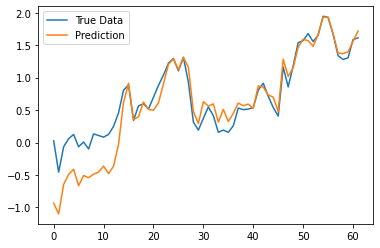

In [147]:
#Let's use the model and predict the stock
predicted_stock_price = model.predict(feature_test)
plot_results(predicted_stock_price,label_test)